In [211]:
#Import all neccessary packages and modules
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats

plt.style.use('ggplot')

#Gives credentials for api access to GCP
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/Users/phillliprashaad/Google_API_Key.json' 

#Connects to medicare data set
import bq_helper
from bq_helper import BigQueryHelper
medicare = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="cms_medicare")
bq_assistant = BigQueryHelper("bigquery-public-data", "cms_medicare")





In [212]:
#Define helper functions
def left_df_merge(df1, df2, col1, col2 ):
    '''Helps left merge data frames
    
        df1:  Left Dataframe
        df2:  Right Dataframe
        col1: Left column to merge on
        col2: Right column to merge on
        
        Returns: Merged Dataframe
    '''
    
    
    df_merge = df1.merge(df2, how='left', 
                            left_on=col1, 
                            right_on=col2 )
    return df_merge


def filter_DF(df, colname, string):
    '''Searches a specific column to see if it contains a given value
        
        df:       The dataframe to search
        colname:  Name of column to search
        string:   String to search
        
        Returns: Filtered Dataframe
    '''
    mask = df[colname].str.contains(string)
    return df[mask]


def row_rank_change(row):
    if row == 1:
        return 5
    elif row == 2:
        return 4
    elif row == 3:
        return 3
    elif row == 4:
        return 2
    else:
        return 1

In [213]:
#There are 23 tables in this database.
bq_assistant.list_tables()

['home_health_agencies_2013',
 'home_health_agencies_2014',
 'hospice_providers_2014',
 'hospital_general_info',
 'inpatient_charges_2011',
 'inpatient_charges_2012',
 'inpatient_charges_2013',
 'inpatient_charges_2014',
 'inpatient_charges_2015',
 'nursing_facilities_2013',
 'nursing_facilities_2014',
 'outpatient_charges_2011',
 'outpatient_charges_2012',
 'outpatient_charges_2013',
 'outpatient_charges_2014',
 'outpatient_charges_2015',
 'part_d_prescriber_2014',
 'physicians_and_other_supplier_2012',
 'physicians_and_other_supplier_2013',
 'physicians_and_other_supplier_2014',
 'physicians_and_other_supplier_2015',
 'referring_durable_medical_equip_2013',
 'referring_durable_medical_equip_2014']

In [214]:
#Focusing on part_d_prescriber_2014 table. Viewing the table schema helps us understand the table layout
bq_assistant.table_schema('part_d_prescriber_2014')

,name,type,mode,description
0,npi,STRING,REQUIRED,National Provider Identifier
1,nppes_provider_last_org_name,STRING,NULLABLE,Last Name/Organization Name of the Provider
2,nppes_provider_first_name,STRING,NULLABLE,First Name of the Provider
3,nppes_provider_city,STRING,NULLABLE,City of the Provider
4,nppes_provider_state,STRING,NULLABLE,State Code of the Provider
5,specialty_description,STRING,NULLABLE,Provider Specialty Type
6,description_flag,STRING,NULLABLE,Source of Provider Specialty
7,drug_name,STRING,REQUIRED,Name of the drug
8,generic_name,STRING,NULLABLE,Generic name of the drug
9,bene_count,INTEGER,NULLABLE,Number of Medicare Beneficiaries


In [215]:
#Looking at the first 15 records of table 'part_d_prescriber_2014' in a Pandas DataFrame
bq_assistant.head('part_d_prescriber_2014', num_rows=15)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_day_supply_ge65,total_drug_cost_ge65,total_30_day_fill_count,total_30_day_fill_count_ge65
0,1003002817,IGLESIAS,NAYVIS,DORAL,FL,Family Practice,S,CILOSTAZOL,CILOSTAZOL,14.0,...,4020,1428.25,NaN,#,110,None,3450,1278.20,134.0,115.0
1,1003009218,NOLEN,JAMES,MORRILTON,AR,Family Practice,S,LORAZEPAM,LORAZEPAM,26.0,...,2900,827.61,14.0,None,56,None,1250,464.61,116.1,56.1
2,1003013756,PHUNG,ANDY,LENOIR,NC,Family Practice,S,ALLOPURINOL,ALLOPURINOL,14.0,...,3540,707.65,NaN,*,42,None,2280,399.14,118.0,76.0
3,1003034851,GUST,AMY,SEVIERVILLE,TN,Family Practice,S,ALLOPURINOL,ALLOPURINOL,21.0,...,4844,849.56,NaN,#,84,None,3944,662.59,162.0,132.0
4,1003070723,BEARD,MARK,SOUTHFIELD,MI,Family Practice,S,HYDROCODONE-ACETAMINOPHEN,HYDROCODONE/ACETAMINOPHEN,65.0,...,6654,6399.23,36.0,None,147,None,3273,3046.12,275.2,149.1
5,1003096587,IRIARTE,MANRIQUE,PEMBROKE PINES,FL,Internal Medicine,S,GLIPIZIDE XL,GLIPIZIDE,NaN,...,1303,513.84,NaN,*,41,None,1303,513.84,43.4,43.4
6,1003243544,MCDONNELL,KATHRYN,POUGHKEEPSIE,NY,Nurse Practitioner,S,GABAPENTIN,GABAPENTIN,23.0,...,2244,966.51,NaN,#,39,None,1224,532.80,75.0,41.0
7,1003803321,TURNER,KENNETH,RUSSELLVILLE,AR,Family Practice,S,MELOXICAM,MELOXICAM,42.0,...,6689,1042.49,NaN,#,136,None,4460,660.38,235.0,160.0
8,1003803552,TOWNE,WILLIAM,GENEVA,IL,Cardiology,S,SIMVASTATIN,SIMVASTATIN,13.0,...,2550,502.81,13.0,None,39,None,2550,502.81,85.0,85.0
9,1003806621,DESANTOLA,JOSEPH,HENDERSONVILLE,NC,Internal Medicine,S,AMLODIPINE BESYLATE,AMLODIPINE BESYLATE,30.0,...,6305,798.13,NaN,#,88,None,4985,643.78,211.0,167.0


In [216]:
#What states had the most overall prescriptions?
#Assumption: States with larger populations will have more prescriptions

query1 = """SELECT
  nppes_provider_state AS state,
  ROUND(SUM(total_claim_count) / 1e6) AS total_claim_count_millions
FROM
  `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
GROUP BY
  state
ORDER BY
  total_claim_count_millions DESC
;
        """
response1 = medicare.query_to_pandas_safe(query1)
response1.head(51)

,state,total_claim_count_millions
0,CA,116.0
1,FL,91.0
2,NY,80.0
3,TX,76.0
4,PA,63.0
5,OH,53.0
6,NC,46.0
7,IL,43.0
8,MI,39.0
9,GA,39.0


In [217]:
#Set SQL Query equal to python variable.
max_presc_by_state = response1.head(51).copy()

max_presc_by_state.set_index('state', inplace=True)

max_presc_by_state.head()

,total_claim_count_millions
state,
CA,116.0
FL,91.0
NY,80.0
TX,76.0
PA,63.0


In [218]:
#The total number of prescriptions in the United States in 2014 was 1.2 billion
max_presc_by_state.sum()

total_claim_count_millions    1227.0
dtype: float64

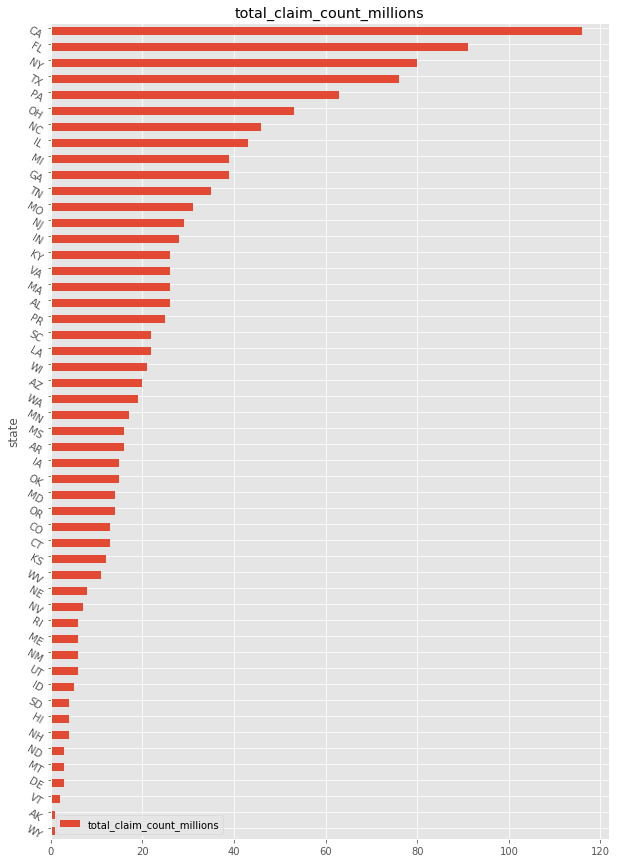

In [219]:
#Graphical representation of table
max_presc_by_state.sort_values('total_claim_count_millions',inplace=True)
max_presc_by_state.plot.barh(rot=-30, subplots=True,figsize =(10,15), position=.9 );

In [220]:
#How many distinct medications are in this table?

RXquery = """SELECT COUNT (DISTINCT drug_name) AS distinct_drugs
FROM `bigquery-public-data.cms_medicare.part_d_prescriber_2014`

        """
response3 = medicare.query_to_pandas_safe(RXquery, max_gb_scanned=10)
response3.head(51)

,distinct_drugs
0,2703


In [221]:
#Lets view the top 5 most prescribed drugs in each state.


ST5query = ''' SELECT * FROM (SELECT nppes_provider_state AS state,
                                generic_name AS drug_name,
                                sum(total_claim_count),
                                RANK () OVER (PARTITION BY nppes_provider_state ORDER BY sum(total_claim_count) DESC) AS row_rank
                                FROM `bigquery-public-data.cms_medicare.part_d_prescriber_2014`
                                GROUP BY nppes_provider_state, drug_name
                                ORDER BY sum(total_claim_count) DESC
                                )
                WHERE row_rank <= 5
                ORDER BY state'''

responseST5 = medicare.query_to_pandas_safe(ST5query, max_gb_scanned=10)
responseST5.head(350)

,state,drug_name,f0_,row_rank
0,AA,AMOXICILLIN,225,1
1,AA,HYDROCODONE/ACETAMINOPHEN,180,2
2,AA,IBUPROFEN,155,3
3,AA,AZITHROMYCIN,78,4
4,AA,METHYLPREDNISOLONE,71,5
...,...,...,...,...
300,ZZ,HYDROCODONE/ACETAMINOPHEN,2232,1
301,ZZ,AMLODIPINE BESYLATE,1076,2
302,ZZ,LISINOPRIL,1046,3
303,ZZ,SIMVASTATIN,1041,4


In [222]:
#Assign state top 5 query to python variable
state_top5_df = responseST5.head(350).copy()

#Rename column "f0_" to 'total_claims_count'
state_top5_df.rename(columns={'f0_':'total_claims_count'}, inplace=True)

#The dataset has erroneous states. These will be cleaned and filtered later
state_top5_df.head()

,state,drug_name,total_claims_count,row_rank
0,AA,AMOXICILLIN,225,1
1,AA,HYDROCODONE/ACETAMINOPHEN,180,2
2,AA,IBUPROFEN,155,3
3,AA,AZITHROMYCIN,78,4
4,AA,METHYLPREDNISOLONE,71,5


In [223]:
#The medication table alone is not enough to test my null hypothesis.
#I suspect population size, race, gender and location will be important variables

In [224]:
#Import population data into dataframe
population_df = pd.read_csv('/Users/phillliprashaad/Desktop/Galvanzie_DSI/Capstone_1/Health Care/import_tables/region_pop_2.csv')

population_df.head()

,SUMLEV,REGION_dig,REGION_name,DIVISION_dig,DIVISION_name,STATE_dig,STATE_abb,NAME,CENSUS2010POP,ESTIMATESBASE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0.0,ALL,0.0,NON DIVISION,0,NaN,United States,308745538,308758105,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1.0,Northeast,0.0,NON DIVISION,0,NaN,Northeast Region,55317240,55318443,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2.0,Midwest,0.0,NON DIVISION,0,NaN,Midwest Region,66927001,66929725,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3.0,South,0.0,NON DIVISION,0,NaN,South Region,114555744,114563030,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4.0,West,0.0,NON DIVISION,0,NaN,West Region,71945553,71946907,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083


In [225]:
#Import demographics table
demographic_df = pd.read_csv('/Users/phillliprashaad/Desktop/Galvanzie_DSI/Capstone_1/Where_Are_The_Drugs/import_tables/demographic_by_state.csv')

demographic_df.head()

,Year.id,Year.display-label,Sex.id,Sex.display-label,Hisp.id,Hisp.display-label,GEO.id,GEO.id2,state.name,state.abb,totpop,white,black,native.american,asian,pacific.islander,multi.racial
0,cen42010,"April 1, 2010 Census",female,Female,hisp,Hispanic,0100000US,NaN,United States,NON STATE,24858794,21936806,1191984,702309,249346,85203,693146
1,cen42010,"April 1, 2010 Census",female,Female,nhisp,Not Hispanic,0100000US,NaN,United States,NON STATE,132105418,100301335,19853611,1147502,7691693,246518,2864759
2,cen42010,"April 1, 2010 Census",female,Female,tothisp,Total,0100000US,NaN,United States,NON STATE,156964212,122238141,21045595,1849811,7941039,331721,3557905
3,cen42010,"April 1, 2010 Census",male,Male,hisp,Hispanic,0100000US,NaN,United States,NON STATE,25618800,22681299,1136129,773939,248654,92206,686573
4,cen42010,"April 1, 2010 Census",male,Male,nhisp,Not Hispanic,0100000US,NaN,United States,NON STATE,126162526,97017621,18068911,1115756,6969823,250698,2739717


In [226]:
#Import cleaned and consolidated 2014 data
consol_percent_2014_df = pd.read_csv('/Users/phillliprashaad/Desktop/Galvanzie_DSI/Capstone_1/Where_Are_The_Drugs/import_tables/consol_percent_2014.csv')

consol_totals_2014_df = pd.read_csv('/Users/phillliprashaad/Desktop/Galvanzie_DSI/Capstone_1/Where_Are_The_Drugs/import_tables/consol_totals_2014.csv')

In [227]:
#Check the column names and datatypes
consol_percent_2014_df.dtypes

state                           object
drug_name                       object
treatment_for                   object
REGION_name                     object
DIVISION_name                   object
row_rank                         int64
total_claims_count_percent     float64
black_female_percent           float64
black_male_percent             float64
white_female_percent           float64
white_male_percent             float64
hispanic_female_percent        float64
hispanic_male_percent          float64
asian_female_percent           float64
asian_male_percent             float64
pac_islander_female_percent    float64
pac_islander_male_percent      float64
nat_amer_female_percent        float64
nat_amer_male_percent          float64
mult_rac_female_percent        float64
mult_rac_male_percent          float64
female_total_percent           float64
male_total_percent             float64
dtype: object

In [228]:
#How often does each drug appear in a state's top 5?
consol_percent_2014_df.drug_name.value_counts()

LEVOTHYROXINE SODIUM         49
LISINOPRIL                   47
OMEPRAZOLE                   36
AMLODIPINE BESYLATE          31
SIMVASTATIN                  30
HYDROCODONE/ACETAMINOPHEN    26
ATORVASTATIN CALCIUM         22
FUROSEMIDE                    7
METOPROLOL SUCCINATE          1
LOSARTAN POTASSIUM            1
Name: drug_name, dtype: int64

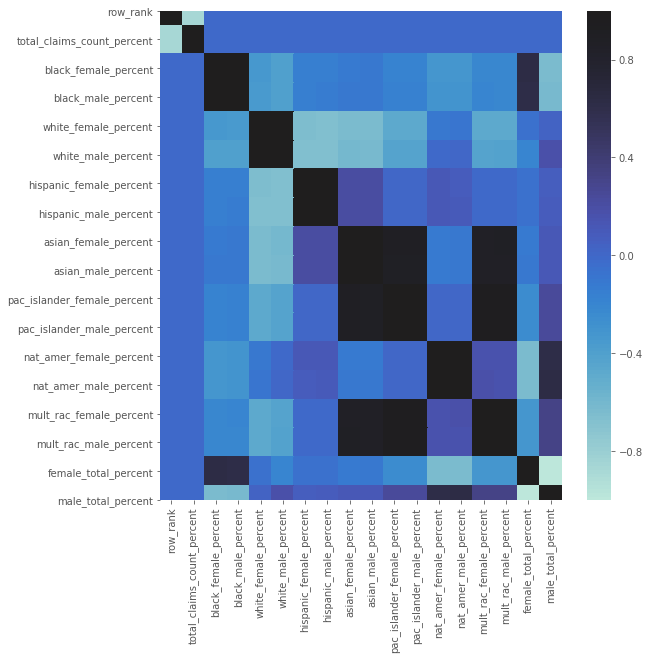

In [229]:
#Heatmap shows the correlations between variables.
plt.subplots(figsize=(9,9))
sns.heatmap(consol_percent_2014_df.corr(), annot=False, center=1);

In [230]:
#Create dataframe that compares females to males by percentage of state population.
male_vs_female_df = consol_percent_2014_df[ ['state','female_total_percent','male_total_percent']].groupby('state').max()
male_vs_female_df.head()

,female_total_percent,male_total_percent
state,,
AK,0.476333,0.523699
AL,0.515306,0.484835
AR,0.508945,0.491168
AZ,0.503054,0.497455
CA,0.503710,0.497020


In [231]:
#Shows important statistics about the columns of interest
male_vs_female_df.describe()

,female_total_percent,male_total_percent
count,50.000000,50.000000
mean,0.505824,0.494316
std,0.008000,0.007990
min,0.476333,0.484145
25%,0.502302,0.488208
50%,0.506940,0.493055
75%,0.512044,0.497904
max,0.515972,0.523699


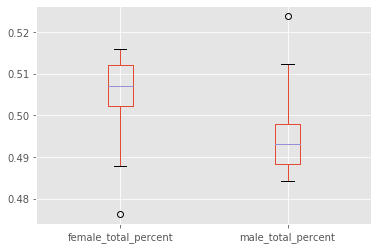

In [232]:
#Overall there are more females than males in the United States
male_vs_female_df.plot.box();

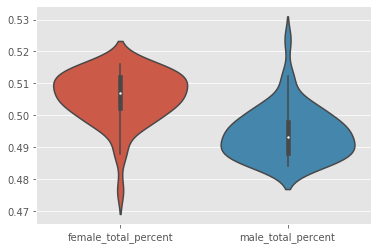

In [233]:
sns.violinplot(data=male_vs_female_df);

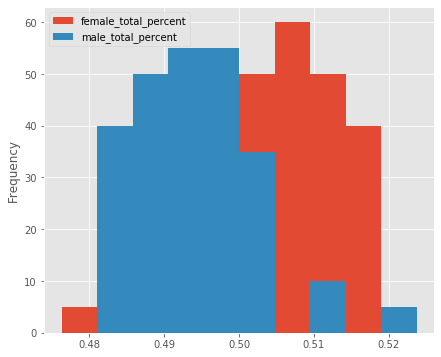

In [234]:
consol_percent_2014_df[ ['female_total_percent','male_total_percent']].plot.hist(figsize=(7,6));

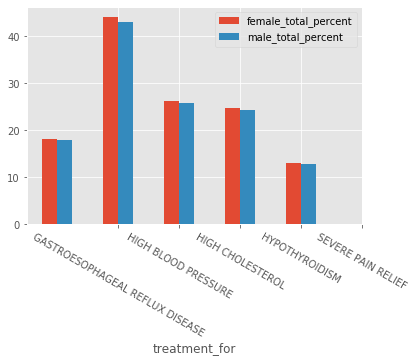

In [235]:
consol_percent_2014_df.groupby('treatment_for').sum().plot.bar(y=['female_total_percent','male_total_percent'], 
                                                                rot=-30,
                                                                position=2.5);

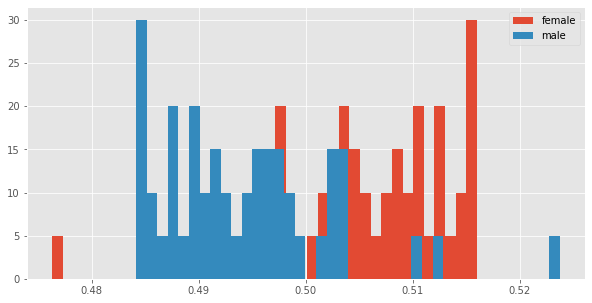

In [236]:
#Plot histogram to see if we have a normal distribution
#WE DO NOT have a normal distribution
fig, axs = plt.subplots(figsize=(10,5))
totalf = consol_percent_2014_df['female_total_percent'] 
totalm = consol_percent_2014_df['male_total_percent'] 


axs.hist(totalf, bins = 40)
axs.hist(totalm, bins = 40)
axs.legend(['female','male']);

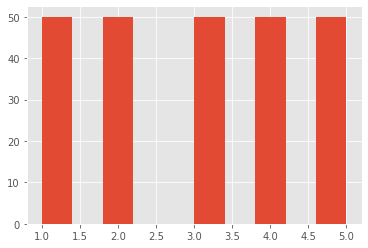

In [237]:
#Row rank is a uniform distribution. (NOT A NORM DIST)
totalr = consol_percent_2014_df['row_rank']
totalr.hist();

In [238]:
#Since we do not have a normal distribution and I want to test for linearity, we are going to use Spearman r Correlation
#We are testing correlation strength between gender percentage and medication rank for drug LEVOTHYROXINE SODIUM
#The function returns (r value, p value)
#The closer the r value to 1 the greater the linearity   
#If p value < alpha, then REJECT Null

#Function that implements Spearman Correlation r-test
def Spearman_r_test(arr1, arr2, alpha):
    r, p = stats.spearmanr(arr1,arr2)
    
    if p < alpha :
        return print('a:{} > p:{}\nR = {}\nREJECT NULL HYPOTHESIS'.format(alpha,p,r))
    else:
        return print('a:{} < p:{}\nR = {}\nDO NOT REJECT NULL HYPOTHESIS'.format(alpha,p,r))
    

In [240]:
#We are going to test at alpha = .01


totalf = filter_DF(consol_percent_2014_df,'drug_name','LEVOTHYROXINE SODIUM')['female_total_percent']
totalr = filter_DF(consol_percent_2014_df,'drug_name','LEVOTHYROXINE SODIUM')['row_rank']

Spearman_r_test(totalf, totalr,.01)

a:0.01 > p:0.0018744952501599753
R = 0.4332337236154801
REJECT NULL HYPOTHESIS


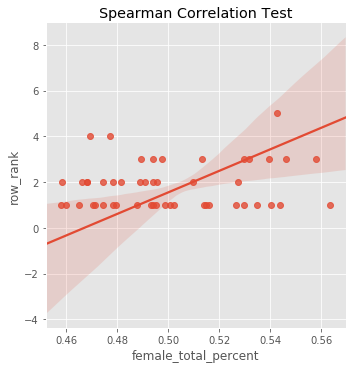

In [259]:
#There is a significant correlation between female population percentage and row rank
#Lets view this graphically

fem_rank = filter_DF(consol_percent_2014_df,'drug_name','LEVOTHYROXINE SODIUM')[['female_total_percent','row_rank']]
fem_rank
sns.lmplot(x='female_total_percent', y='row_rank', data=fem_rank, x_jitter=.05)
plt.title('Spearman Correlation Test');

In [242]:
#Lets research different variables in our data
consol_percent_2014_df

,state,drug_name,treatment_for,REGION_name,DIVISION_name,row_rank,total_claims_count_percent,black_female_percent,black_male_percent,white_female_percent,...,asian_female_percent,asian_male_percent,pac_islander_female_percent,pac_islander_male_percent,nat_amer_female_percent,nat_amer_male_percent,mult_rac_female_percent,mult_rac_male_percent,female_total_percent,male_total_percent
0,AK,HYDROCODONE/ACETAMINOPHEN,SEVERE PAIN RELIEF,West,Pacific,4,0.165460,0.014071,0.018940,0.290837,...,0.030748,0.027848,0.005832,0.006019,0.071217,0.073136,0.031959,0.032239,0.476333,0.523699
1,AK,LEVOTHYROXINE SODIUM,HYPOTHYROIDISM,West,Pacific,2,0.198270,0.014071,0.018940,0.290837,...,0.030748,0.027848,0.005832,0.006019,0.071217,0.073136,0.031959,0.032239,0.476333,0.523699
2,AK,LISINOPRIL,HIGH BLOOD PRESSURE,West,Pacific,1,0.277399,0.014071,0.018940,0.290837,...,0.030748,0.027848,0.005832,0.006019,0.071217,0.073136,0.031959,0.032239,0.476333,0.523699
3,AK,OMEPRAZOLE,GASTROESOPHAGEAL REFLUX DISEASE,West,Pacific,3,0.195315,0.014071,0.018940,0.290837,...,0.030748,0.027848,0.005832,0.006019,0.071217,0.073136,0.031959,0.032239,0.476333,0.523699
4,AK,SIMVASTATIN,HIGH CHOLESTEROL,West,Pacific,5,0.163557,0.014071,0.018940,0.290837,...,0.030748,0.027848,0.005832,0.006019,0.071217,0.073136,0.031959,0.032239,0.476333,0.523699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,WY,HYDROCODONE/ACETAMINOPHEN,SEVERE PAIN RELIEF,West,Mountain,5,0.162391,0.004829,0.007162,0.415487,...,0.004743,0.003856,0.000335,0.000352,0.010676,0.010563,0.007850,0.008085,0.489516,0.510514
246,WY,LEVOTHYROXINE SODIUM,HYPOTHYROIDISM,West,Mountain,1,0.305112,0.004829,0.007162,0.415487,...,0.004743,0.003856,0.000335,0.000352,0.010676,0.010563,0.007850,0.008085,0.489516,0.510514
247,WY,LISINOPRIL,HIGH BLOOD PRESSURE,West,Mountain,2,0.198659,0.004829,0.007162,0.415487,...,0.004743,0.003856,0.000335,0.000352,0.010676,0.010563,0.007850,0.008085,0.489516,0.510514
248,WY,OMEPRAZOLE,GASTROESOPHAGEAL REFLUX DISEASE,West,Mountain,4,0.162748,0.004829,0.007162,0.415487,...,0.004743,0.003856,0.000335,0.000352,0.010676,0.010563,0.007850,0.008085,0.489516,0.510514


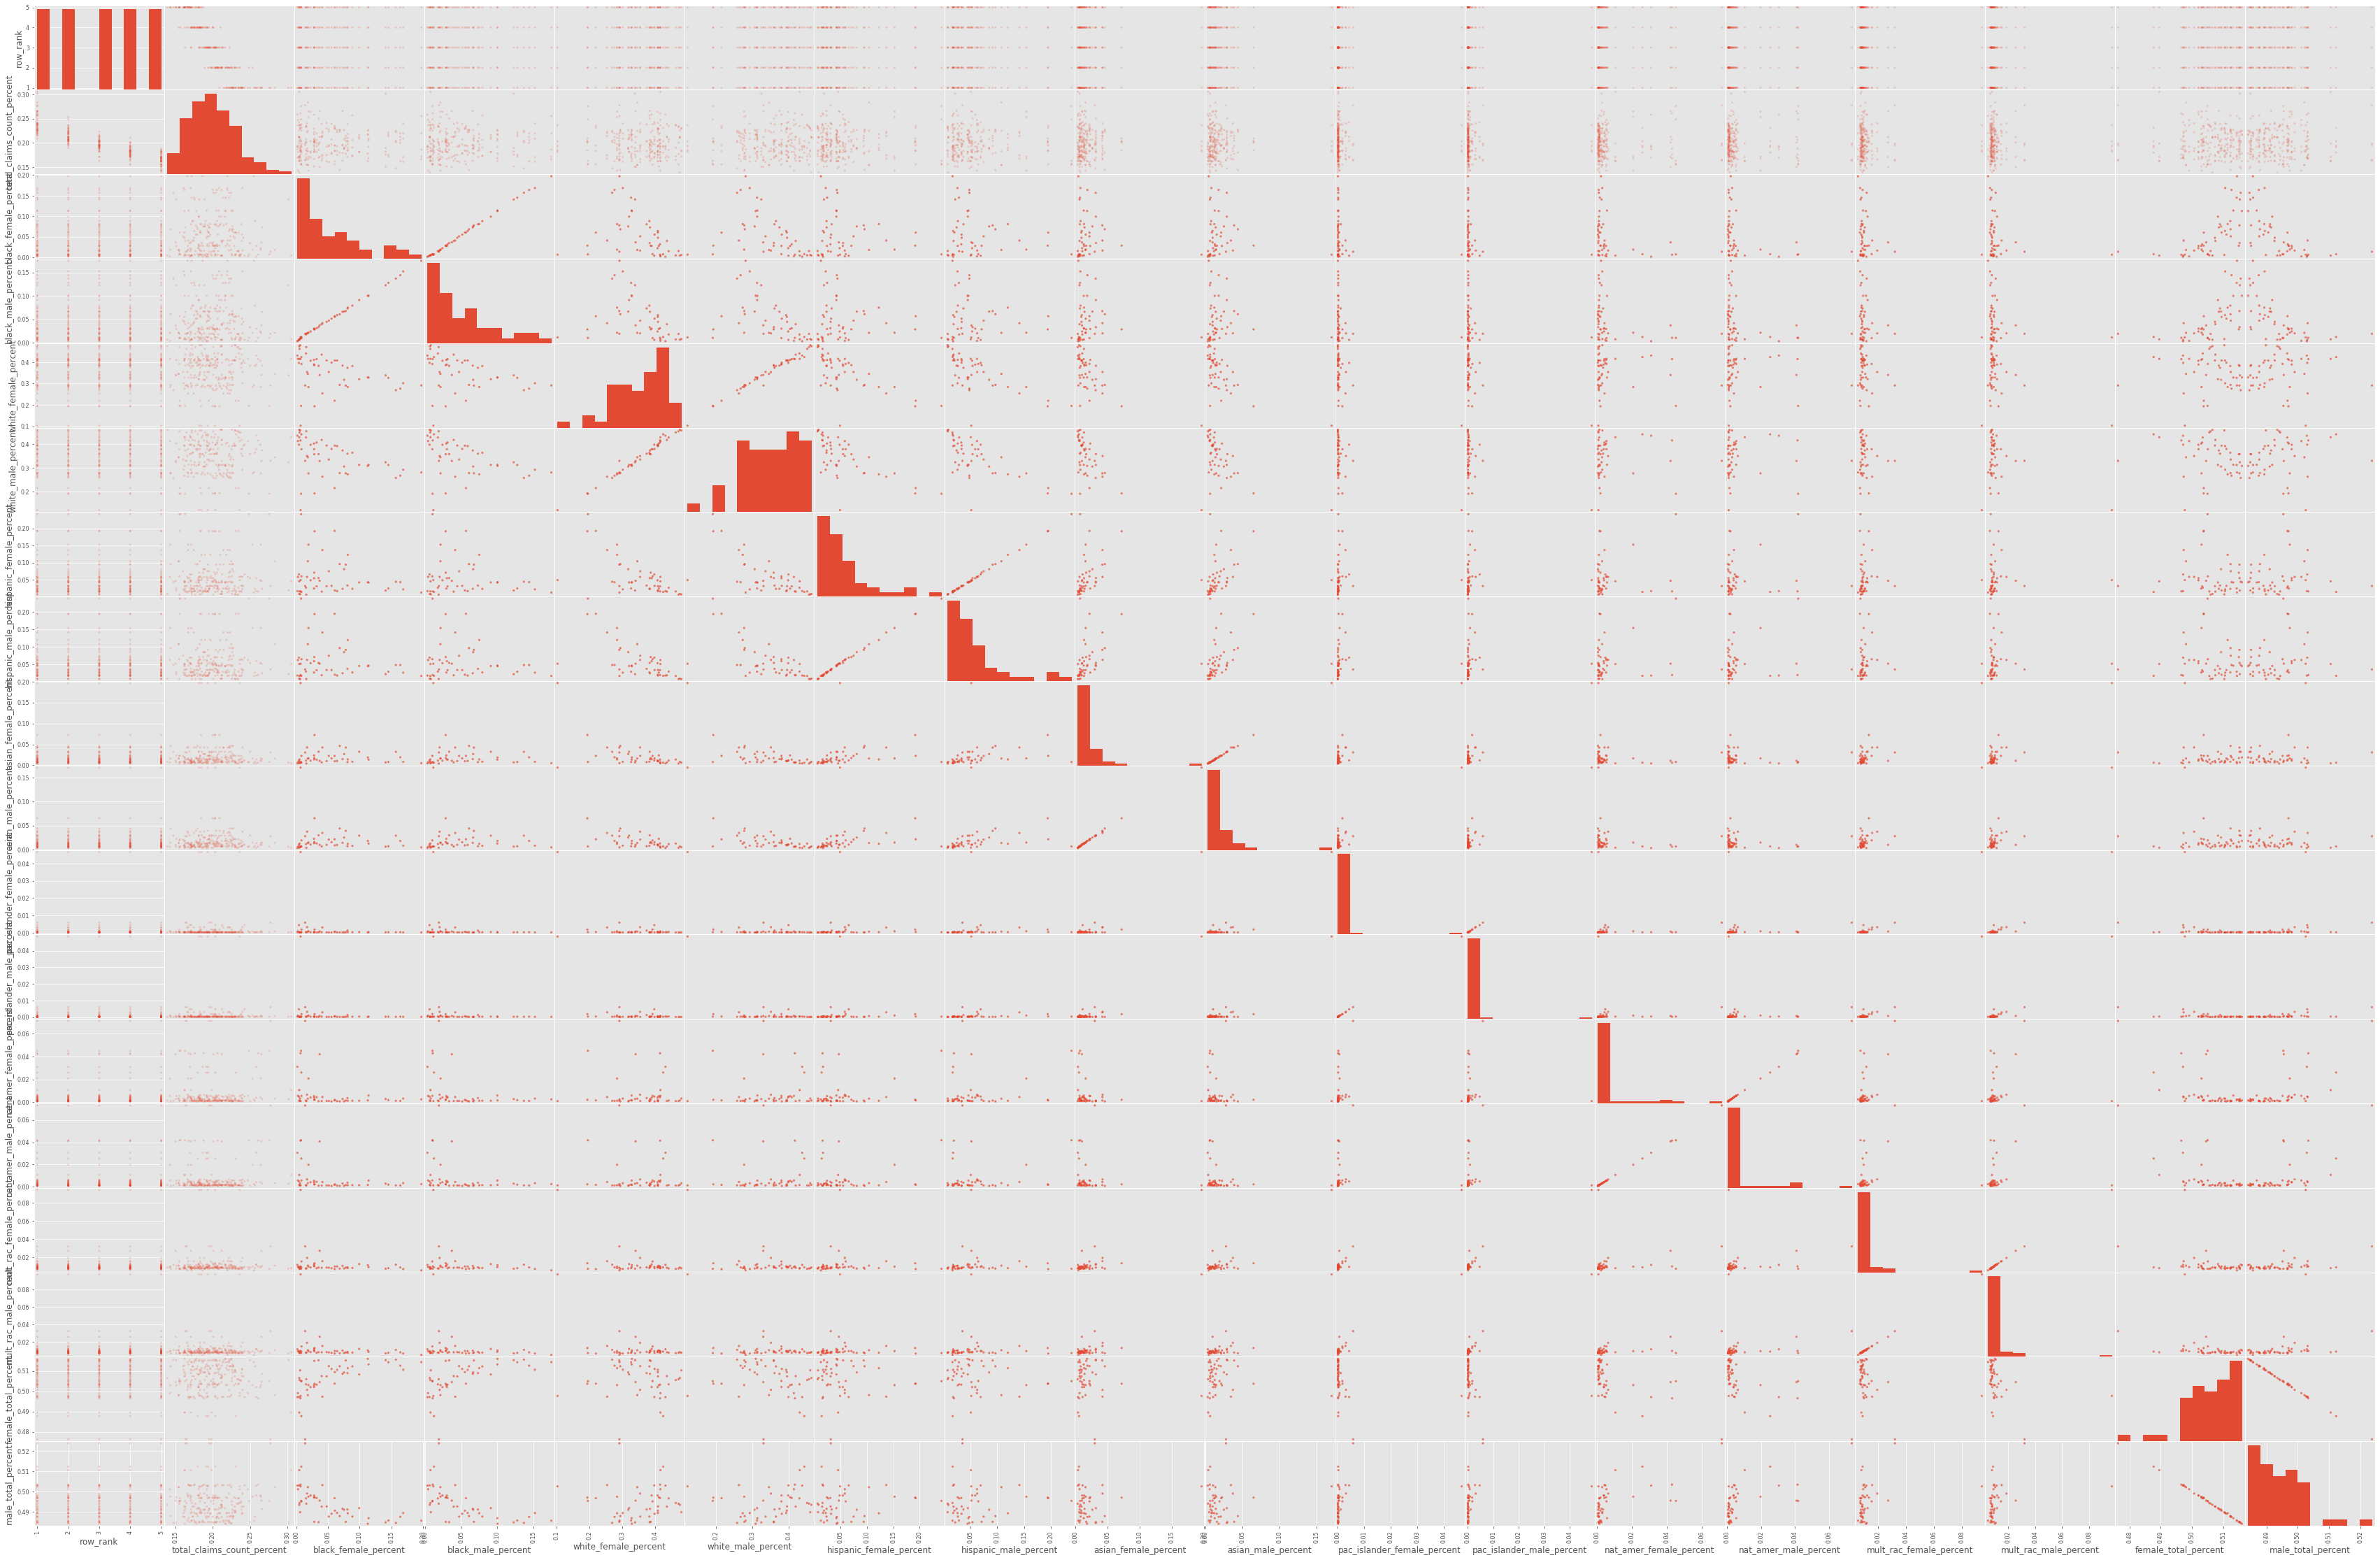

In [243]:
#The scatter matrix will allow us to see if there are any variables that are normally distributed
( pd.plotting.scatter_matrix(consol_percent_2014_df.applymap(lambda x:x*1), 
                            alpha=0.2, figsize=(60,40), diagonal='hist') );

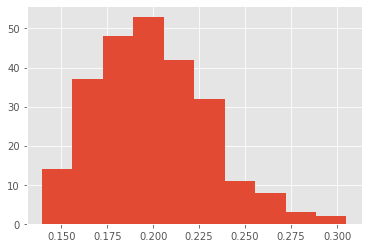

In [244]:
#From the scatter matrix above we see that total_claims_count_percent has the only normal distribution
drug_claims_percent = consol_percent_2014_df['total_claims_count_percent']
drug_claims_percent.hist();

In [245]:
#Lets view all the statistics
drug_claims_percent.describe()

count    250.000000
mean       0.200000
std        0.030202
min        0.139501
25%        0.177804
50%        0.196381
75%        0.219752
max        0.305112
Name: total_claims_count_percent, dtype: float64

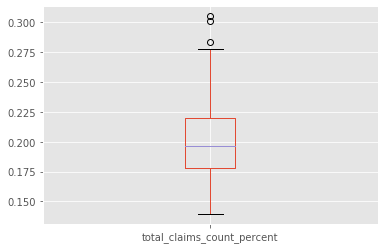

In [246]:
#Lets look at the statistics graphically
#We can see there are 3 outliers
drug_claims_percent.plot.box()

In [247]:
#Lets take 2 drugs from this sample and compare them
#We are going to compare LEVOTHYROXINE SODIUM and LISINOPRIL (Both appear in most states)

#We only want columns state, drug_name, and total_claims_count_percent
drug_group3 = consol_percent_2014_df[['state','drug_name','total_claims_count_percent']]
drug_group3.head(10)

,state,drug_name,total_claims_count_percent
0,AK,HYDROCODONE/ACETAMINOPHEN,0.165460
1,AK,LEVOTHYROXINE SODIUM,0.198270
2,AK,LISINOPRIL,0.277399
3,AK,OMEPRAZOLE,0.195315
4,AK,SIMVASTATIN,0.163557
5,AL,AMLODIPINE BESYLATE,0.175900
6,AL,HYDROCODONE/ACETAMINOPHEN,0.301445
7,AL,LEVOTHYROXINE SODIUM,0.182166
8,AL,LISINOPRIL,0.151157
9,AL,OMEPRAZOLE,0.189332


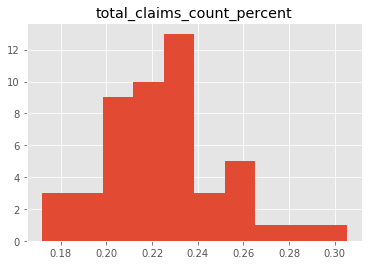

In [248]:
#Looking at the distribution of LEVOTHYROXINE SODIUM
#It appears roughly normally distributed
drug_LEVO = drug_group3[drug_group3['drug_name']=='LEVOTHYROXINE SODIUM'].copy()
drug_LEVO.hist();

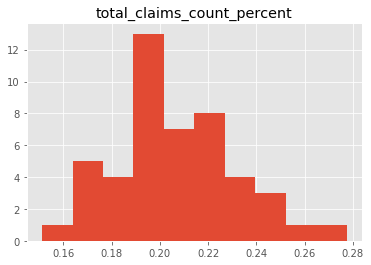

In [249]:
#Looking at the distribution of LISINOPRIL
#It also appears roughly normally distributed
drug_LISI = drug_group3[drug_group3['drug_name']=='LISINOPRIL'].copy()
drug_LISI.hist();

In [250]:
#Both drugs do not appear in the same amount of states
print('LEVO in {} states\nLISI in {} states'.format(len(drug_LEVO.total_claims_count_percent),
                                                    len(drug_LISI.total_claims_count_percent)))

LEVO in 49 states
LISI in 47 states


In [251]:
#renaming the columns to be distinct in each data frame
drug_LEVO.rename(columns={'total_claims_count_percent':'LEVO_percent'}, inplace=True)
drug_LISI.rename(columns={'total_claims_count_percent':'LISI_percent'}, inplace=True)

#Merging the norm dist dataframes
LEVO_LISI_merge = left_df_merge(drug_LISI,drug_LEVO,'state','state').copy()

#Filter out NaN values
LEVO_LISI_merge.dropna(inplace=True)

LEVO_LISI_merge.head()

,state,drug_name_x,LISI_percent,drug_name_y,LEVO_percent
0,AK,LISINOPRIL,0.277399,LEVOTHYROXINE SODIUM,0.198270
1,AL,LISINOPRIL,0.151157,LEVOTHYROXINE SODIUM,0.182166
2,AR,LISINOPRIL,0.202516,LEVOTHYROXINE SODIUM,0.204468
3,AZ,LISINOPRIL,0.253205,LEVOTHYROXINE SODIUM,0.264604
4,CO,LISINOPRIL,0.224818,LEVOTHYROXINE SODIUM,0.283237


[Text(0, 0, 'LEVOTHYROXINE\nSODIUM'), Text(0, 0, 'LISINOPRIL')]

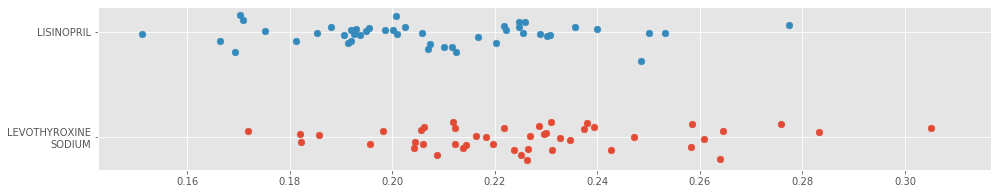

In [252]:
#Inital view of data graphically
LEVO = LEVO_LISI_merge.LEVO_percent
LISI = LEVO_LISI_merge.LISI_percent

fig, ax = plt.subplots(1, figsize=(16, 3))

ax.scatter(LEVO, np.repeat(0, len(LEVO)) + np.random.normal(0, 0.1, len(LEVO)), s=45)
ax.scatter(LISI, np.repeat(1, len(LISI)) + np.random.normal(0, 0.1, len(LISI)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["LEVOTHYROXINE\nSODIUM", "LISINOPRIL"])

In [260]:
#The scatter plot above looks like LEVO consistently has a larger claims percentage than LISI
#NULL HYPOTHESIS: There is no signficant difference between drugs LEVO and LISI
#ALT HYPOTHESIS: There is a signficant difference between drugs LEVO and LISI
#We are going to use Welch's t-test
#Welch's t-test requires the calculation of the T-value and p-value
#If p < .01 ,then REJECT NULL

#Create a function to implement Welch's t-test

def welch_ttest(arr1, arr2, alpha):
    t_welch, p_welch = stats.ttest_ind(arr1,arr2)

    if alpha > p_welch:
        return print('a:{} > p:{}\nT value = {}\nREJECT NULL HYPOTHESIS'.format(alpha,p_welch,t_welch))
    else:
        return print('a:{} < p:{}\nT value = {}\n DO NOT REJECT NULL HYPOTHESIS'.format(alpha,p_welch,t_welch))
    


In [261]:
welch_ttest(LEVO,LISI,.01)

a:0.01 > p:0.0007530980635432155
T value = 3.4887838834617826
REJECT NULL HYPOTHESIS


In [255]:
#Since the calc p value is less than alpha we REJECT NULL HYPOTHESIS
#Meaning there is a signficant difference in claims perecentage between the drugs LEVOTHYROXINE SODIUM and LISINOPRIL

#Defining a function to look at test graphically
def compare_plot(arr1,arr2):    
    plt.figure()

    ax1 = sns.distplot(arr1,color='orange')
    ax2 = sns.distplot(arr2,color='b')

    plt.axvline(np.mean(arr1), color='orange', linestyle='dashed', linewidth=3)
    plt.axvline(np.mean(arr2), color='b', linestyle='dashed', linewidth=3)
    
    plt.title('{} vs {}'.format(arr1.name,arr2.name))
    plt.legend([arr1.name,arr2.name])


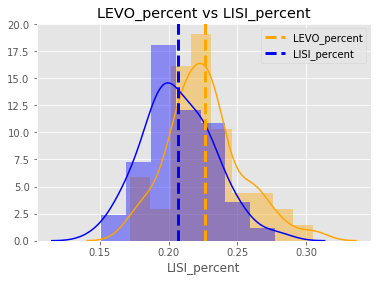

In [256]:
#Use function to plot comparison
compare_plot(LEVO,LISI)